# Data exploration and descriptive statistics

## Importing necessary libraries and packages

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS

## Loading the datasets into pandas dataframe

In [121]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

## Taking a peek into the datasets and doing some mild preprocessing

I will only be using the movies, ratings and tags dataset in this notebook.

In [122]:
print(movies.info())
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found in the movies or ratings dataset and the variables are in a usable format

In [123]:
print(ratings.info())
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


I will be dropping the timestamp column from 'ratings' df because it is unnecessary to keep it

In [124]:
print(tags.info())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [125]:
#dropping the timestamp column because we don't need it
ratings = ratings.drop('timestamp', axis = 1)

Merging the movies and ratings dataframes for use later in this notebook

In [126]:
movie_ratings = pd.merge(movies, ratings)
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


## Descriptive Statistics

The descriptive statistics of the movies dataset below does not provide any useful information

In [127]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


An analysis of the descriptive statistics of ratings df shows that the minimum rating score is 0.5 and the maximum is 5.0. The mean rating score is ~3.5 with a standard deviation of ~1.04

In [128]:
ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


# Data Visualizations

## Distribution of rating score in ratings df

Showing the distribution of ratings given in the ratings dataset. In the plot below, we see that the rating scale ranges from 0.5 to 5.0 with increments of 0.5. The most prevalent ratings given are 3.0, and 4.0 with 5.0 coming in third. We also see that people were less likely to give low ratings as evidenced by the low number of movies rated between 0.5 and 2.5.

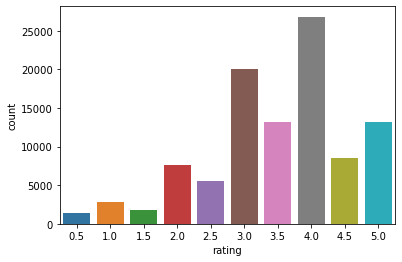

In [129]:
import seaborn as sns
sns.countplot(x = ratings.rating);

## Wordcloud showing most frequent words in the movie titles

From the wordcloud below, we can see that we have quite a few franchises in the dataset as evidenced by the bold lettering of 'II' and 'III'. We also have a lot of movies about 'love' apparently

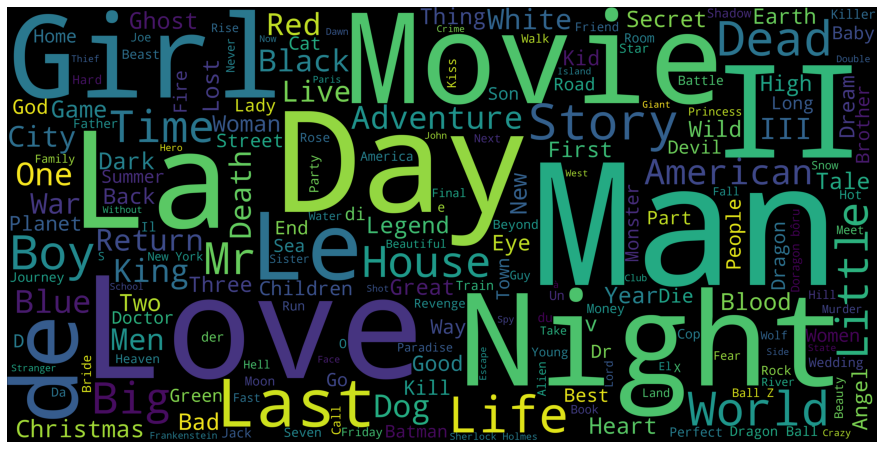

In [130]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The function in the cell below gives us a frequency distribution of the genres in the movies df. We can see that Drama, Comedy, Thriller, Action and Romance are the most frequently mentioned genres in descending order.

In [131]:
# getting the census of the genre keywords
genre_labels = set()
for genre in movies['genres'].str.split('|').values:
    genre_labels.update(genre)

# Function that gets the frequency distribution of the genre keywords
def keyword_count(dataset, column, keywords):
    keyword_dict = {key:0 for key in keywords}
    for genre in dataset[column].str.split('|'):                
        for key in [key for key in genre if key in keywords]: 
            if pd.notna(key): 
                keyword_dict[key] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_dict.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_dict

# Calling this function gives access to a list of genre keywords which are sorted by descending order of frequency
keyword_occurences, keyword_dict = keyword_count(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

## Wordcloud below shows the prevalence of genres in the dataset.

Creating a bag of words for the genre keywords

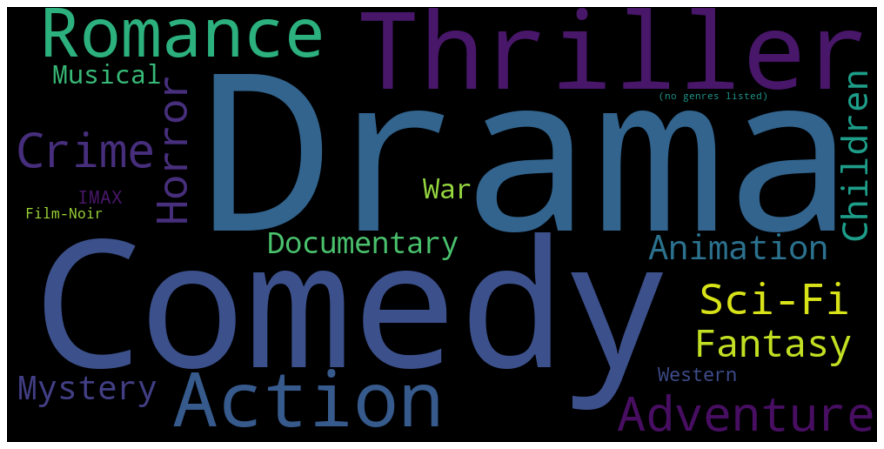

In [132]:
# Create the wordcloud of genres keywords
genre_wordcloud = WordCloud(width=1000,height=500, background_color='black')
genre_wordcloud.generate_from_frequencies(keyword_dict)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [57]:
# mean_ratings = movie_ratings.groupby('title')['rating'].mean().sort_values(ascending=False)[:10]

# Content Based

## Merging the movie_ratings df with the tags df

This is because I want to use the genres as well as the tags for the recommendation system 

In [133]:
mt_ratings = pd.merge(movie_ratings, tags).drop('timestamp', axis = 1)
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,4.0,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,4.0,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,3.5,fun
3,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,fantasy
4,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,magic board game


## Splitting each genre variable, removing the '|' symbol and converting them to lowercase

In [135]:
mt_ratings['genres'] = mt_ratings['genres'].apply(lambda x: ''.join(x.replace('|', ' ').lower()))
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),adventure animation children comedy fantasy,336,4.0,pixar
1,1,Toy Story (1995),adventure animation children comedy fantasy,474,4.0,pixar
2,1,Toy Story (1995),adventure animation children comedy fantasy,567,3.5,fun
3,2,Jumanji (1995),adventure children fantasy,62,4.0,fantasy
4,2,Jumanji (1995),adventure children fantasy,62,4.0,magic board game
...,...,...,...,...,...,...
3471,187595,Solo: A Star Wars Story (2018),action adventure children sci-fi,62,4.0,star wars
3472,193565,Gintama: The Movie (2010),action animation comedy sci-fi,184,3.5,anime
3473,193565,Gintama: The Movie (2010),action animation comedy sci-fi,184,3.5,comedy
3474,193565,Gintama: The Movie (2010),action animation comedy sci-fi,184,3.5,gintama


## Creating a new column that takes in the features in genres and tag columns per row

In [136]:
def combined_features(row):
    return row['genres']+" "+row['tag']
mt_ratings["combined_features"] = mt_ratings.apply(combined_features, axis =1)

In [140]:
#resetting the index of the dataframe
mt_ratings.reset_index(inplace = True)

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#Instantiating CountVectorizer
count_vec = CountVectorizer()
# convert the contents of the combined features into a matrix of token counts
count_matrix = count_vec.fit_transform(mt_ratings["combined_features"])
#Calculating the cosine similarity of the movies in the count_matrix
cosine_sim = pd.DataFrame(cosine_similarity(count_matrix))

## Creating a class for the recommendation system

I decided to create a class for this because it's more efficient than typing out the functions individually and it's much neater and readable

In [240]:
class ContentBasedRec:

    #     instantiate the class object variables
    def __init__(self,name,df):
        self.name = name
        self.df = df
        self.title = df['title']
        self.index = df['index']

        # getting the index of the movie in question
    def title_index(self):
        return self.df[self.title == self.name]["index"].values[0]

    #     getting the index of the movies most similar to the movie selected
    def similar_movies(self):
        self.title_index()
        similar_movies = list(enumerate(cosine_sim[self.title_index()]))
        return sorted(similar_movies, key=lambda x:x[1], reverse=True)

    #     using the index of the movies to get the movie titles and recommending the first 15 most similar movies
    def movie_list(self):
        movie_list = []
        for movie in self.similar_movies():
            movie_index = movie[0]
            movie_title = self.df[self.index == movie_index]["title"].values[0]
            if movie_title not in movie_list:
                movie_list.append(movie_title)
            else:
                 pass
            if len(movie_list)==15:
                print('Here are a few recommendations for you')
                return movie_list

# Collaborative Filtering

## Taking a look at the number of unique user ids and movie ids in the ratings df

In [244]:
# checking the unique number of user id and movie id in the ratings dataset
print(len(ratings['userId'].unique()), 'Number of user ids')
print(len(ratings['movieId'].unique()), 'Number of movie ids')

610 Number of user ids
9724 Number of movie ids


In [245]:
#reading in the range og ratings score
reader = Reader(rating_scale = (1,5))
#loading the dataframe into surprise
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
dataset = data.build_full_trainset()

In [ ]:
knn_basic = KNNBasic(sim_options = {'name':'pearson', 'user_based':True})
cv_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [ ]:
for i in cv_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_basic['test_rmse']))

In [ ]:
# ratings_df = ratings.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)

In [ ]:
#cross_validation with knnwithmeans
knn_means = KNNWithMeans(sim_options={'name':'pearson', 'user_based':True})
cv_means = cross_validate(knn_means, data, n_jobs=-1)

In [ ]:
# ratings_df.head()

In [ ]:
for i in cv_means.items():
    print(i)
print('-----------------------')
print(np.mean(cv_means['test_rmse']))

In [ ]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_baseline = cross_validate(knn_baseline, data)

In [ ]:
for i in cv_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_baseline['test_rmse']))

In [ ]:
grid = {'n_factors' : [20,100],'n_epochs' : [5,10], 'reg_all' : [0.4, 0.6], 
              'lr_all' : [0.002, 0.005], }
gs_model = GridSearchCV(SVD, param_grid = grid, n_jobs = -1)
gs_model.fit(data)

In [ ]:
gs_model.best_params

In [ ]:
gs_model.best_score

In [ ]:
p_grid = {'n_factors' : [10,90],'n_epochs' : [10,20], 'reg_all' : [0.1, 0.4], 
              'lr_all' : [0.005, 0.009], }
gs_model2 = GridSearchCV(SVD, param_grid = p_grid, n_jobs = -1)
gs_model2.fit(data)

In [ ]:
gs_model2.best_params

In [ ]:
gs_model2.best_score

In [ ]:
grid3 = {'n_factors' : [20,100],'n_epochs' : [20,30], 'reg_all' : [0.05, 0.1], 
              'lr_all' : [0.009, 0.01], }
gs_model3 = GridSearchCV(SVD, param_grid = grid3, n_jobs = -1)
gs_model3.fit(data)

In [ ]:
gs_model3.best_params

In [ ]:
gs_model3.best_score

In [ ]:
grid4 = {'n_factors' : [20,100],'n_epochs' : [30,40], 'reg_all' : [0.1, 0.2], 
              'lr_all' : [0.01, 0.05], }
gs_model4 = GridSearchCV(SVD, param_grid = grid4, n_jobs = -1)
gs_model4.fit(data)

In [ ]:
gs_model4.best_params

In [ ]:
gs_model4.best_score

In [ ]:
grid5 = {'n_factors' : [20,100],'n_epochs' : [40,60], 'reg_all' : [0.1, 0.2], 
              'lr_all' : [0.01, 0.05], }
gs_model5 = GridSearchCV(SVD, param_grid = grid5, n_jobs = -1)
gs_model5.fit(data)

In [ ]:
gs_model5.best_params

In [ ]:
gs_model5.best_score